In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastparquet

In [18]:
df = pd.read_parquet("meow_df.parquet", engine = 'fastparquet')

df.columns

df['time_diff'] = df.seconds_in_bucket - df.seconds_in_bucket_before

df = df.query("""time_id == time_id_before and stock_id == stock_id_before""")

df = df.drop(columns = ['time_id_before', 'seconds_in_bucket_before', 'stock_id_before', 'level_0'])

df['trade'] = (df.price >= df.ask_price1_before).astype(int) - (df.price <= df.bid_price1_before).astype(int)

In [19]:
df['mid'] = (df.ask_price1 + df.bid_price1)/2

df['spread'] = (df.ask_price1 - df.bid_price1)*10000/df.mid

<Axes: ylabel='Frequency'>

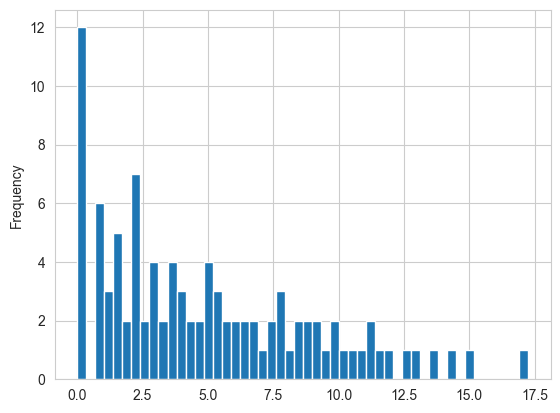

In [20]:
np.log(df.time_diff.value_counts()).plot.hist(bins = 50)

In [21]:
#meow moew

In [22]:
target = pd.read_csv("baseline.csv",index_col="Unnamed: 0")



gb = df.groupby(by=['stock_id', 'time_id']).agg({"size":"sum", "spread": "mean","time_diff":"max"})
gb['log_time_diff'] = np.log(gb.time_diff)

In [23]:
target = target.merge(gb.reset_index())

In [24]:
avg_per_stock = target.groupby('stock_id')['log_time_diff'].transform('mean')

In [25]:
target['timefunc'] = np.abs(target['log_time_diff']- avg_per_stock)**.5


#timef = gb.apply(func = timefunc, axis=1)

In [26]:
target.timefunc.describe()

count    428910.000000
mean          0.569108
std           0.246931
min           0.041650
25%           0.376883
50%           0.567450
75%           0.749598
max           1.651136
Name: timefunc, dtype: float64

<Axes: ylabel='Frequency'>

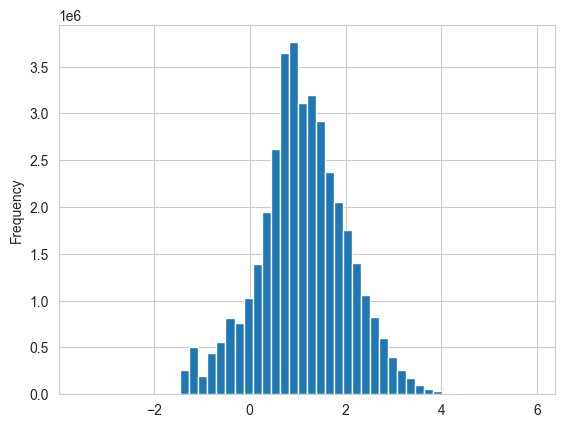

In [27]:
np.log(df.spread).plot.hist(bins = 50)

<Axes: ylabel='Frequency'>

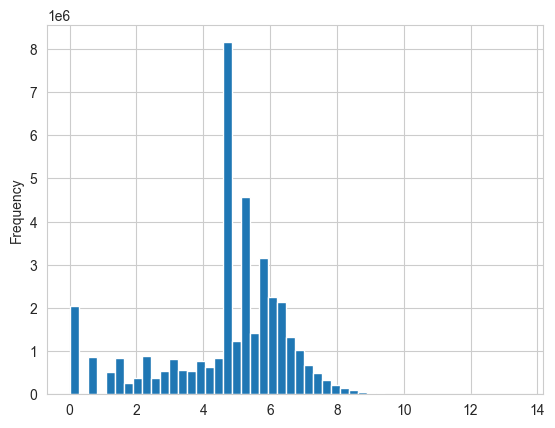

In [28]:
pd.Series(np.log(df['size'])).plot.hist(bins = 50)

<Axes: xlabel='spread', ylabel='target'>

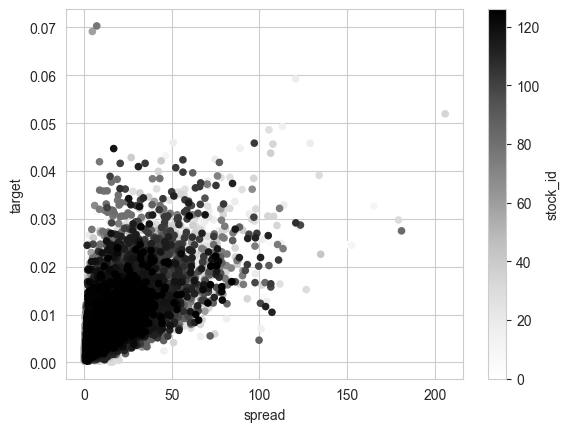

In [29]:
target.plot.scatter(x="spread", y="target",c= "stock_id")
#spread very high corr with vol. unsurprising

array([[<Axes: xlabel='sigma', ylabel='sigma'>,
        <Axes: xlabel='target', ylabel='sigma'>,
        <Axes: xlabel='size', ylabel='sigma'>,
        <Axes: xlabel='spread', ylabel='sigma'>,
        <Axes: xlabel='time_diff', ylabel='sigma'>,
        <Axes: xlabel='log_time_diff', ylabel='sigma'>,
        <Axes: xlabel='timefunc', ylabel='sigma'>],
       [<Axes: xlabel='sigma', ylabel='target'>,
        <Axes: xlabel='target', ylabel='target'>,
        <Axes: xlabel='size', ylabel='target'>,
        <Axes: xlabel='spread', ylabel='target'>,
        <Axes: xlabel='time_diff', ylabel='target'>,
        <Axes: xlabel='log_time_diff', ylabel='target'>,
        <Axes: xlabel='timefunc', ylabel='target'>],
       [<Axes: xlabel='sigma', ylabel='size'>,
        <Axes: xlabel='target', ylabel='size'>,
        <Axes: xlabel='size', ylabel='size'>,
        <Axes: xlabel='spread', ylabel='size'>,
        <Axes: xlabel='time_diff', ylabel='size'>,
        <Axes: xlabel='log_time_diff', ylabel='

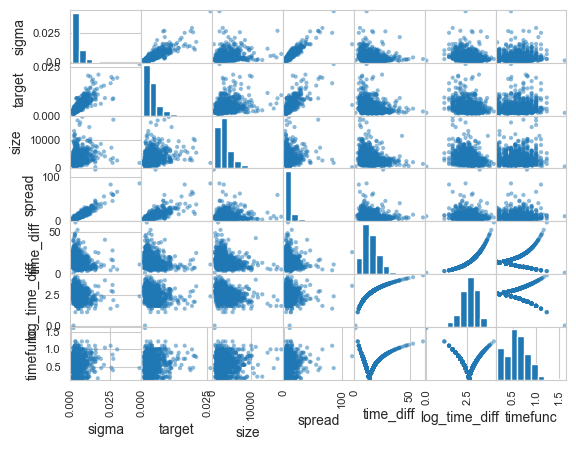

In [30]:

pd.plotting.scatter_matrix(target.head(1000).drop(columns=['stock_id','time_id']))

#Size low corr with sigma: prob due to low corr size ~ volume

<Axes: xlabel='timefunc', ylabel='target'>

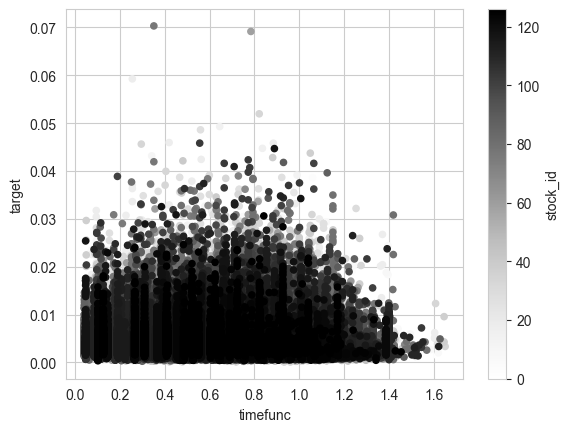

In [31]:
target.plot.scatter(x= "timefunc", y = "target", c="stock_id")

#Hmm very liquid mala sigma, illiquid tez, mid liquid duze zmiany?

In [32]:
target.corr().target.sort_values()
#cool

stock_id        -0.021662
time_id         -0.010341
time_diff        0.031866
size             0.036413
timefunc         0.064945
log_time_diff    0.065225
spread           0.753375
sigma            0.873780
target           1.000000
Name: target, dtype: float64

In [33]:
target.to_csv("baseline2.csv")
df.to_parquet("clean_trades.parquet", engine='fastparquet')

In [34]:
target.head()

,stock_id,time_id,sigma,target,size,spread,time_diff,log_time_diff,timefunc
0,0,5,0.004499,0.004136,3179,7.922559,15,2.708050,0.310975
1,0,11,0.001204,0.001445,1287,4.118409,23,3.135494,0.723982
2,0,16,0.002369,0.002168,2161,6.476585,35,3.555348,0.971598
3,0,31,0.002574,0.002195,1962,7.627233,28,3.332205,0.849035
4,0,62,0.001894,0.001747,1791,4.302927,25,3.218876,0.779443


In [126]:
target['stock_id'] = target['stock_id'].astype('category')

In [159]:
def print_stats(x, y, model):
    y_pred = model.predict(x)
    error = rmsre(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(error)
    print(r2)

In [160]:
from sklearn.model_selection import train_test_split

X = target.drop(columns=['time_id', 'log_time_diff', 'target'])
y = target['target']

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [162]:
X_train.head()

,stock_id,sigma,size,spread,time_diff,timefunc
339437,100,0.004893,14874,7.907818,12,0.502035
61584,17,0.012423,9952,15.127924,6,0.320466
144732,40,0.002413,707,6.477650,18,0.643113
155181,43,0.001869,370701,0.473768,1,0.356821
315731,94,0.001642,6939,2.482414,9,0.393618


In [163]:
y

0         0.004136
1         0.001445
2         0.002168
3         0.002195
4         0.001747
            ...   
428905    0.003461
428906    0.003113
428907    0.004070
428908    0.003357
428909    0.002090
Name: target, Length: 428910, dtype: float64

In [166]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(n_estimators=3000, max_depth=3, enable_categorical=True)
model_xgb.fit(X_train, y_train)
print_stats(X_test, y_test, model_xgb)

0.2934588336133338
0.7953076768499876


In [167]:
print_stats(X_train, y_train, model_xgb)

0.28731467126638016
0.8165707172334609


In [168]:
print(model_xgb.feature_importances_)

[0.02381974 0.93193763 0.01009731 0.01383648 0.01235045 0.00795835]


In [169]:
X_train.columns

Index(['stock_id', 'sigma', 'size', 'spread', 'time_diff', 'timefunc'], dtype='object')

In [170]:
len(X_train)

343128

In [176]:
target.stock_id.dtype

CategoricalDtype(categories=['0', '1', '10', '100', '101', '102', '103', '104', '105',
                  '107',
                  ...
                  '89', '9', '90', '93', '94', '95', '96', '97', '98', '99'],
, ordered=False)

In [179]:
target_1 = target[target['stock_id'] == '1']

In [180]:
target_1.head()

,stock_id,time_id,sigma,target,size,spread,time_diff,log_time_diff,timefunc
3830,1,5,0.006245,0.006340,10008,5.820127,2,0.693147,1.150938
3831,1,11,0.002305,0.002099,4181,4.591680,8,2.079442,0.248265
3832,1,16,0.002517,0.002456,11451,2.485666,7,1.945910,0.268134
3833,1,31,0.003570,0.002807,2087,6.920944,20,2.995732,0.988902
3834,1,62,0.002903,0.004312,1162,7.132320,20,2.995732,0.988902


In [181]:
x = target_1.drop(columns=['stock_id', 'time_id', 'target'])
y = target_1['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [182]:
def rmsre(y_true, y_pred):
    return np.mean(((y_true - y_pred) / y_true)**2)**0.5

In [183]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
error = rmsre(y_test, y_pred)
print(error)
r2 = r2_score(y_test, y_pred)
print(r2)

0.2979839338627268
0.7319682502098547


In [184]:
xgb_model = xgb.XGBRegressor(n_estimators=7500, max_depth=3)
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
error = rmsre(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(error)
print(r2)

0.2562187376076883
0.7589341860679621


In [185]:
def print_stats(x, y, model):
    y_pred = model.predict(x)
    error = rmsre(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(error)
    print(r2)

In [186]:
print_stats(x_train, y_train, xgb_model)

0.2274672174343242
0.8175946632610283


In [187]:
print_stats(x_test, y_test, xgb_model)

0.2562187376076883
0.7589341860679621


In [189]:
target['target'].describe()

count    428910.000000
mean          0.003880
std           0.002936
min           0.000105
25%           0.002026
50%           0.003048
75%           0.004738
max           0.070321
Name: target, dtype: float64

In [195]:
quantile_99 = np.quantile(target['target'], q=0.99)
print(quantile_99)

0.01520426542999998


In [196]:
target_high_vol = target.query(f'target > {quantile_99}')

In [197]:
print(len(target_high_vol) / len(target))

0.010002098342309576


<Axes: xlabel='target', ylabel='sigma'>

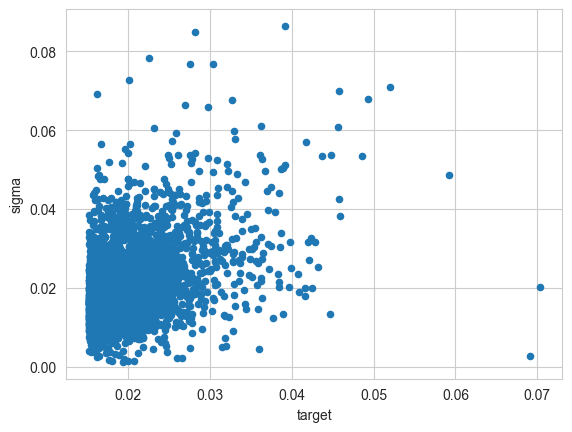

In [200]:
target_high_vol.plot.scatter(x='target', y='sigma')